## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 1. Exploratory Data Analysis </span>

In [1]:
import pandas as pd

polusa_balanced_2017_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2017_1.csv', header = 0)
polusa_balanced_2017_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2017_2.csv', header = 0)

polusa_balanced_2018_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2018_1.csv', header = 0)
polusa_balanced_2018_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2018_2.csv', header = 0)

polusa_balanced_2019_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2019_1.csv', header = 0)
polusa_balanced_2019_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2019_2.csv', header = 0)

In [2]:
polusa_balanced = pd.concat([polusa_balanced_2017_1, polusa_balanced_2017_2, polusa_balanced_2018_1, polusa_balanced_2018_2, polusa_balanced_2019_1, polusa_balanced_2019_2], axis = 0)
polusa_balanced.head()

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning
0,55171935,2017-01-01 00:00:00,Los Angeles Times,Afghan refugees coming to California struggle ...,NaN,California's capital has emerged as a leading ...,Associated Press,www.latimes.com,http://www.latimes.com/local/lanow/la-me-ln-af...,LEFT
1,55208434,2017-01-01 00:00:00,NBC News,Minimum Wages Will Rise in Nearly Two Dozen St...,"Twenty-two states, plus the District of Columb...",Play Facebook\nTwitter\nGoogle Plus\nEmbed Tru...,Emma Margolin,www.nbcnews.com,http://www.nbcnews.com/news/us-news/minimum-wa...,CENTER
2,55172357,2017-01-01 00:00:00,Los Angeles Times,Fire engulfs Long Beach apartment unit; man fo...,NaN,A man was found dead as a fire engulfed an apa...,Rong-Gong Lin Ii,www.latimes.com,http://www.latimes.com/local/lanow/la-me-ln-lo...,LEFT
3,115892789,2017-01-01 00:00:00,ABC News,Obama Boosted White House Technology; Trump Se...,Obama Boosted White House Technology; Trump Se...,As Barack Obama began preparing to leave offic...,Abc News,abcnews.go.com,http://abcnews.go.com/Technology/wireStory/oba...,CENTER
4,4375253,2017-01-01 00:00:00,Fox News,Most residents evacuated by sinkhole could ret...,The new public works commissioner in a suburba...,The new public works commissioner in a suburba...,NaN,www.foxnews.com,http://www.foxnews.com/us/2017/01/01/most-resi...,RIGHT


### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.1. Key Features to Use </span>

- Check for null values.

In [3]:
polusa_balanced.isna().sum()

id                        0
date_publish              0
outlet                    0
headline                 26
lead                  64944
body                      0
authors              172938
domain                    0
url                       0
political_leaning         0
dtype: int64

- Since only 26 rows are missing headlines in both datasets, we should drop them.
- Drop the lead column because summarizing the body captures essential information more effectively, making it redundant.
- Drop the authors column since it won’t be used in the recommendation pipeline.

In [4]:
# Drop rows with missing headlines
polusa_balanced = polusa_balanced.dropna(subset = ["headline"])

# Drop irrelevant columns
polusa_balanced = polusa_balanced.drop(columns = ["lead", "authors"])

- Remove `UNDEFINED` political leaning tag to ensure only well-classified political content is used for training, maintaining balanced political representation in recommendations.

In [5]:
polusa_balanced = polusa_balanced[polusa_balanced['political_leaning'] != 'UNDEFINED'].reset_index(drop = True)

In [6]:
polusa_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668333 entries, 0 to 668332
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 668333 non-null  int64 
 1   date_publish       668333 non-null  object
 2   outlet             668333 non-null  object
 3   headline           668333 non-null  object
 4   body               668333 non-null  object
 5   domain             668333 non-null  object
 6   url                668333 non-null  object
 7   political_leaning  668333 non-null  object
dtypes: int64(1), object(7)
memory usage: 40.8+ MB


### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.2 Body Summarizing </span>

Need to summarize the body or the articles as it is very long:
- Reduce Noise: The original text often contains irrelevant or repetitive information. Summarization extracts key points, removing unnecessary content.
- Improve Efficiency: Shorter text makes the recommender system faster and more accurate.
- Better Similarity Calculation: Summaries help the model focus on core ideas, enhancing content-based recommendation quality.

In [7]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

# Define sumy summarization function
def summarize_text(text, num_sentences = 3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join([str(sentence) for sentence in summary])

# Define summarization function
def summarize_row(text):
    return summarize_text(text, num_sentences = 3)

In [8]:
from joblib import Parallel, delayed

# Set number of cores
num_cores = 8

# Apply parallel processing
results = Parallel(n_jobs = num_cores, backend = "loky")(delayed(summarize_row)(text) for text in polusa_balanced["body"])
polusa_balanced["body_summary"] = results
polusa_balanced["text"] = polusa_balanced["headline"] + " " + polusa_balanced["body_summary"]

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.3 Text Cleaning </span>

- Remove extra whitespaces: Remove leading, trailing, and extra spaces.
- Remove Special Characters: Eliminate non-alphanumeric characters (e.g., !@#$%) as they add noise.
- Convert to Lowercase: Standardize text for better token matching.
- Remove Stopwords: Remove common words (e.g., "the", "is") that don’t add significant meaning.
- Lemmatization: Reduce words to their base form (e.g., "running" → "run").

In [9]:
import re
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define the text cleaning function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Remove special characters
    text = re.sub(r'\W', ' ', str(text))  

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove not alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    # Lemmatization and stop words removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]
    
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Apply parallel processing for text cleaning
tokens_results = Parallel(n_jobs = num_cores, backend = "loky")(
    delayed(clean_text)(text) for text in polusa_balanced["text"]
)

polusa_balanced["tokens"] = tokens_results
polusa_balanced["text_cleaned"] = [" ".join(tokens) for tokens in tokens_results]

In [11]:
polusa_balanced.to_csv("../data/polusa_balanced.csv", index = False)

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.4 Bias Analysis </span>

- The goal is to analyze real-world selection biases.

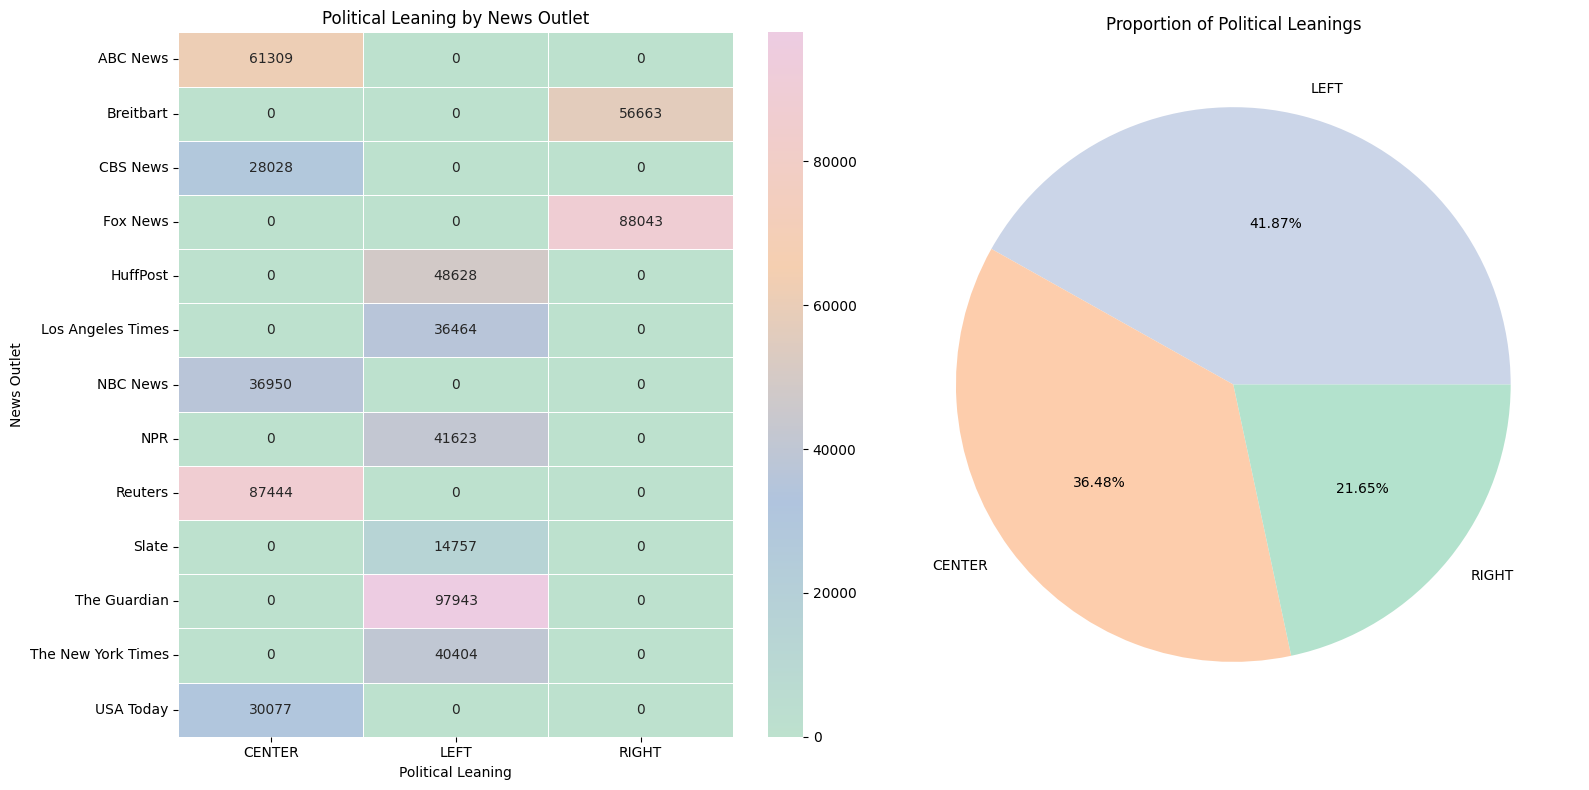

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

pastel_palette = sns.blend_palette(["#BDE1CE", "#B0C4DE", "#F5CFB0", "#EDCCE2"], as_cmap = True)
pastel2_colors = sns.color_palette("Pastel2")[:4]
political_color_map_pastel2 = {
    "RIGHT": pastel2_colors[0],
    "CENTER": pastel2_colors[1],
    "LEFT": pastel2_colors[2],
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Political Leaning by News Outlet
outlet_political_distribution = polusa_balanced.groupby(["outlet", "political_leaning"]).size().unstack(fill_value = 0)
sns.heatmap(outlet_political_distribution, cmap = pastel_palette, annot = True, fmt = "d", linewidths = 0.5, ax = axes[0])
axes[0].set_title("Political Leaning by News Outlet")
axes[0].set_xlabel("Political Leaning")
axes[0].set_ylabel("News Outlet")

# Proportion of Political Leanings
political_counts = polusa_balanced["political_leaning"].value_counts()
labels = political_counts.index
colors = [political_color_map_pastel2[label] for label in labels]
political_counts.plot(
    kind = "pie", autopct = '%1.2f%%', colors = colors, labels = labels, ax = axes[1]
)
axes[1].set_ylabel("")  # Remove 'Count' label
axes[1].set_title("Proportion of Political Leanings")

plt.tight_layout()
plt.show()


- **Selection Bias**: The dataset is skewed towards center-leaning outlets, which represent 46.17% of the total articles, compared to 19.71% (Left) and 10.85% (Right). This imbalance in source representation means that a news recommendation system trained on this dataset may naturally favor centrist perspectives over left or right perspectives.
- **Media Bias**: Certain media outlets dominate within each political leaning, reinforcing specific narratives, amplifying editorial biases, and making it harder for diverse viewpoints to surface in recommendations. Some outlets contribute disproportionately to specific leanings. For instance:
    - Reuters (Center) has an overwhelming 517,193 articles, significantly more than any other source.
    - The Guardian (Left) contributes 105,923 articles, making it one of the primary left-leaning sources.
    - Fox News (Right) is a dominant right-leaning outlet, contributing 88,043 articles, but right-leaning sources are fewer in general.
    - NBC News (Center), ABC News (Center), and BBC (Undefined) also have a strong presence, influencing the dataset's balance.

The recommendation system would inherently prefer articles from overrepresented sources (e.g., Reuters, The Guardian, Fox News) rather than equally distributing news from different ideological perspectives.

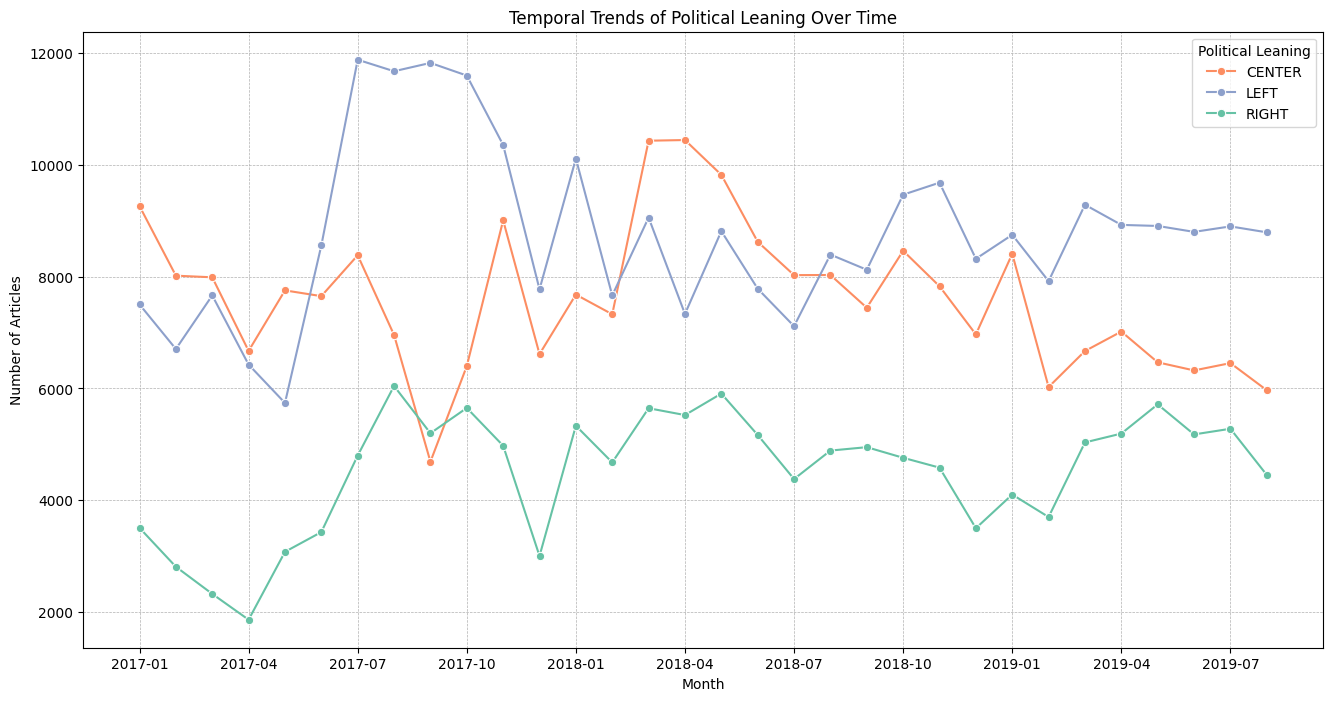

In [13]:
polusa_balanced["date_publish"] = pd.to_datetime(polusa_balanced["date_publish"])
polusa_balanced["year"] = polusa_balanced["date_publish"].dt.year
polusa_balanced["year_month"] = polusa_balanced["date_publish"].dt.to_period("M").astype(str)

monthly_distribution = polusa_balanced.groupby(["year_month", "political_leaning"]).size().reset_index(name = "count")
polusa_balanced['year_month'] = polusa_balanced['date_publish'].dt.to_period('M')

set2_colors = sns.color_palette("Set2")[:4]
political_color_map_set2 = {
    "RIGHT": set2_colors[0],
    "CENTER": set2_colors[1],
    "LEFT": set2_colors[2],
}

# Temporal Trends of Political Leaning Over Time
plt.figure(figsize=(16, 8))
ax = sns.lineplot(data = monthly_distribution, x = "year_month", y = "count", hue = "political_leaning", marker="o", palette = political_color_map_set2)
x_labels = monthly_distribution["year_month"].unique()
ax.set_xticks(x_labels[::3])
ax.legend(title = "Political Leaning")
plt.ylabel("Number of Articles")
plt.xlabel("Month")
plt.title("Temporal Trends of Political Leaning Over Time")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

- **Selection Bias**: If a user engages primarily with news from a period where one political leaning was dominant, the recommendation system might reinforce that preference rather than diversifying exposure.
- **Exposure Bias**: Center-leaning news had the highest article volume throughout 2017-2019, meaning users engaging with news during these years were more exposed to centrist perspectives. 2018 had a significant increase in Undefined sources, particularly mid-year, while Left decreased and Right remained the lowest. If users trained a recommendation model during this period, it might lead to a bias favoring Undefined perspectives (ignoring that Center stories were more prevalent overall).

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


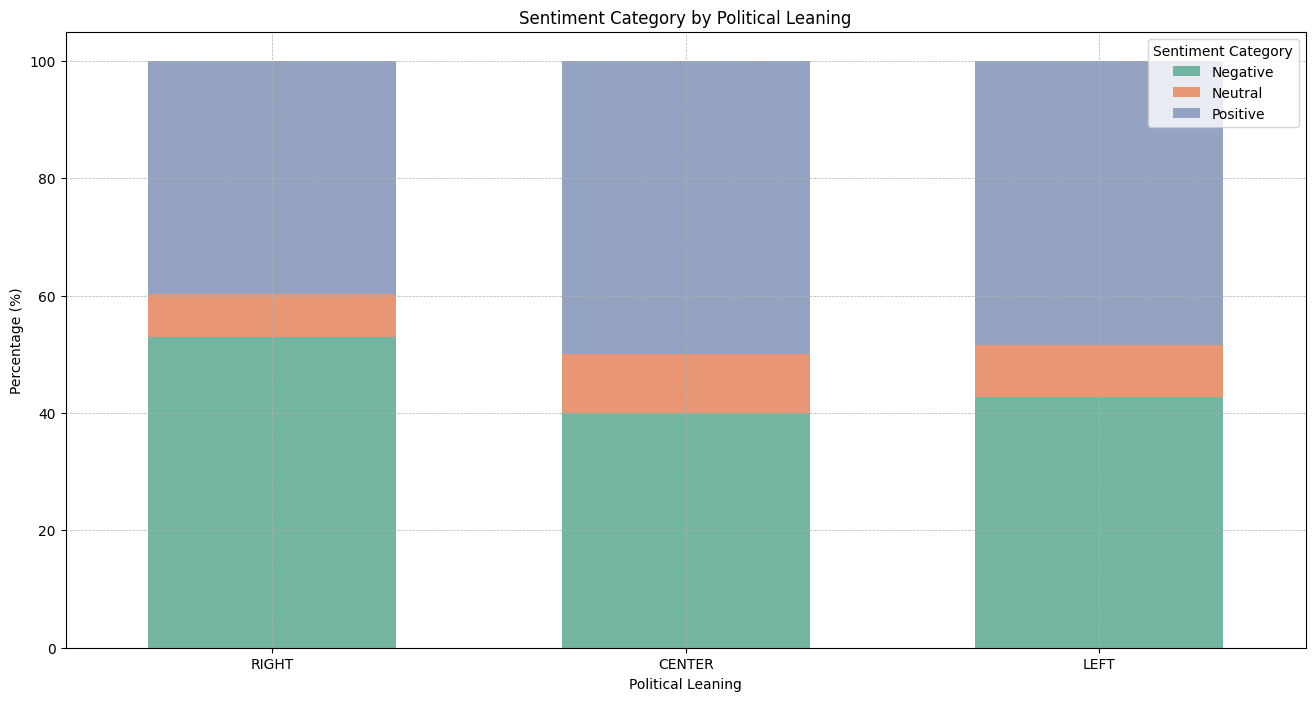

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK sentiment lexicon if not already downloaded
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Compute sentiment score
polusa_balanced["text_sentiment"] = polusa_balanced["text_cleaned"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Function to categorize sentiment
def categorize_sentiment(score):
    if score <= -0.2:
        return "Negative"
    elif score >= 0.2:
        return "Positive"
    else:
        return "Neutral"

# Apply categorization
polusa_balanced["sentiment_category"] = polusa_balanced["text_sentiment"].apply(categorize_sentiment)

# Compute sentiment distribution
sentiment_distribution = polusa_balanced.groupby(["political_leaning", "sentiment_category"]).size().unstack()
sentiment_distribution = sentiment_distribution.div(sentiment_distribution.sum(axis = 1), axis = 0) * 100
sentiment_palette = {"Negative": set2_colors[0], "Neutral": set2_colors[1], "Positive": set2_colors[2]}

# Sentiment Category by Political Leaning
plt.figure(figsize=(16, 8))

categories = ["RIGHT", "CENTER", "LEFT"]
sentiment_distribution = sentiment_distribution.reindex(categories)
bottom_values = None

for sentiment in ["Negative", "Neutral", "Positive"]:
    sns.barplot(x = sentiment_distribution.index, y = sentiment_distribution[sentiment], color = sentiment_palette[sentiment], label = sentiment, width = 0.6, bottom = bottom_values)
    bottom_values = sentiment_distribution[sentiment] if bottom_values is None else bottom_values + sentiment_distribution[sentiment]

plt.legend(title="Sentiment Category")
plt.title("Sentiment Category by Political Leaning")
plt.xlabel("Political Leaning")
plt.ylabel("Percentage (%)")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

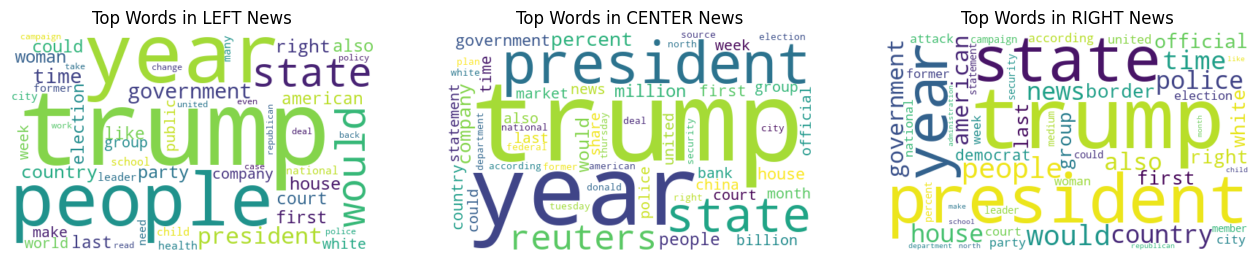

In [15]:
from collections import Counter
from wordcloud import WordCloud

leanings = ["LEFT", "CENTER", "RIGHT"]
excluded_words = {"said", "saying", "told", "says", "say", "report", "reported"}

# Top Words in News by Political Leaning
fig, axes = plt.subplots(1, 3, figsize = (16, 8))
for i, leaning in enumerate(leanings):
    text = " ".join(polusa_balanced[polusa_balanced["political_leaning"] == leaning]["text_cleaned"])
    filtered_words = [word for word in text.split() if word not in excluded_words]
    word_freq = Counter(filtered_words).most_common(50)    
    wordcloud = WordCloud(width = 500, height = 300, background_color = "white").generate_from_frequencies(dict(word_freq))    
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Top Words in {leaning} News")
plt.show()

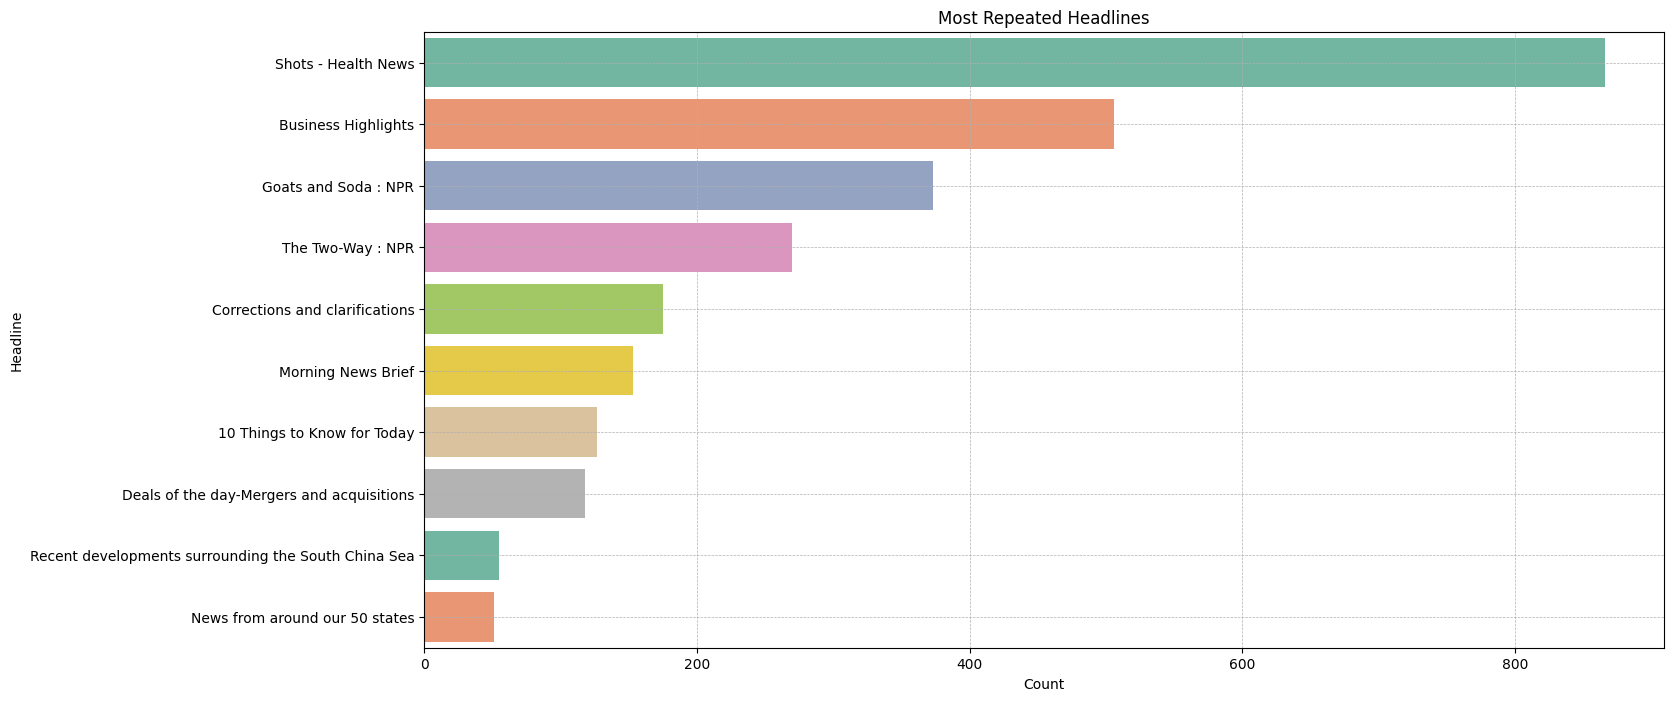

In [16]:
popular_articles = polusa_balanced["headline"].value_counts().nlargest(10)

plt.figure(figsize = (16, 8))
sns.barplot(x = popular_articles.values, y = popular_articles.index, hue = popular_articles.index, palette = "Set2")
plt.title("Most Repeated Headlines")
plt.xlabel("Count")
plt.ylabel("Headline")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 2. News Recommender System (NRS) </span>

In [1]:
import pandas as pd

polusa_balanced = pd.read_csv('../data/polusa_balanced.csv', header = 0)

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 2.1 TF-IDF </span>

<div style="text-align: justify;">

 - TF-IDF matrices are usually sparse, meaning they contain many zero values, which makes computation faster.
 - Complexity: $O(N^2 · d)$  where d is the number of features (words).
 - For 400,000+ articles: It can take minutes to hours depending on the machine and the TF-IDF matrix sparsity.

Instead of computing all pairwise similarities, we use Nearest Neighbors Search for fast retrieval
</div>

In [60]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

def fairness_re_ranking(recommendations, max_per_outlet = 2):
    """
    Solves: Popularity Bias (Big media outlets dominate recommendations)
    Limits each outlet to appear at most max_per_outlet times.
    """
    outlet_counts = Counter()
    balanced_recommendations = []

    for _, row in recommendations.iterrows():
        if outlet_counts[row['outlet']] < max_per_outlet:
            balanced_recommendations.append(row)
            outlet_counts[row['outlet']] += 1

    return pd.DataFrame(balanced_recommendations).reset_index(drop = True)

def enforce_political_diversity(recommendations, top_n=5):
    """
    Enforces a more complex political diversity strategy:
    - Dynamically assigns quota based on `top_n` to balance political diversity.
    - Prioritizes topically relevant articles while ensuring ideological variety.
    - Falls back to alternative articles if strict quotas are not met.
    """

    # Dynamically Define Quotas Based on `top_n`
    if top_n >= 5:
        quota = {'LEFT': max(1, top_n // 3), 'CENTER': max(1, top_n // 3), 'RIGHT': max(1, top_n // 3)}
    else:
        quota = {'LEFT': 1, 'CENTER': 1, 'RIGHT': 1}  # Small lists maintain balance
    
    selected_articles = []
    remaining_articles = recommendations.copy()

    # Enforce Minimum Quotas
    for leaning, min_count in quota.items():
        candidates = remaining_articles[remaining_articles['political_leaning'] == leaning].head(min_count)
        selected_articles.extend(candidates.to_dict('records'))
        remaining_articles = remaining_articles[~remaining_articles['id'].isin([a['id'] for a in selected_articles])]

    # Fill Remaining Slots Using Best Available (Re-Ranking)
    remaining_articles = remaining_articles.sort_values(by='political_leaning', key=lambda x: x.map(quota.get), ascending=False)
    
    # Allowing some flexibility in diversity but keeping high relevance
    selected_articles.extend(remaining_articles.to_dict('records')[:top_n - len(selected_articles)])

    # Final Re-Rank to Prioritize Balanced Distribution
    selected_articles = sorted(selected_articles, key=lambda x: (quota.get(x['political_leaning'], 0), x['date_publish']), reverse=True)

    return pd.DataFrame(selected_articles).reset_index(drop=True)

def recommend_articles_bias_controlled(article_id, df, top_n = 5, base_days_window = 5, max_days_window = 10):
    """
    Ensures fairness in recommendations by controlling outlet diversity and political diversity.
    Fixes previous issues where TF-IDF similarity alone dictated recommendations.
    """
    # Step 1: Get reference date & adaptively filter articles within the rolling window
    reference_date = pd.to_datetime(df.loc[df['id'] == article_id, 'date_publish']).values[0]
    reference_date = pd.to_datetime(reference_date).date()

    min_date = reference_date - pd.Timedelta(days = base_days_window)
    max_date = reference_date + pd.Timedelta(days = base_days_window)

    df['date_only'] = pd.to_datetime(df['date_publish']).dt.date
    time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()
    
    # Expand window if too few articles exist
    while len(time_filtered_df) < top_n * 3 and (max_date - reference_date).days < max_days_window:
        min_date -= pd.Timedelta(days = 1)
        max_date += pd.Timedelta(days = 1)
        time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()

    time_filtered_df = time_filtered_df.drop(columns = ['date_only']).reset_index(drop = True)

    # Step 2: Handle case where too few articles exist
    if len(time_filtered_df) < top_n:
        return time_filtered_df[['id', 'date_publish', 'headline', 'outlet', 'political_leaning']].head(top_n)

    # Step 3: Compute TF-IDF for time-filtered articles & fit Nearest Neighbors model
    vectorizer = TfidfVectorizer(max_features = 50_000)
    tfidf_filtered = vectorizer.fit_transform(time_filtered_df['text_cleaned'])

    nn_filtered = NearestNeighbors(n_neighbors = min(top_n * 3, len(time_filtered_df)), metric = 'cosine', algorithm = 'auto', n_jobs = -1)
    nn_filtered.fit(tfidf_filtered)

    # Step 4: Find correct index of article in filtered dataset
    idx_filtered = time_filtered_df.index[time_filtered_df['id'] == article_id].tolist()
    if not idx_filtered:
        return pd.DataFrame()
    idx_filtered = idx_filtered[0]

    # Step 5: Query Nearest Neighbors model (Get More Than Needed)
    distances, indices = nn_filtered.kneighbors(tfidf_filtered[idx_filtered])
    recommended_articles = time_filtered_df.iloc[indices[0][1:top_n * 3]].copy().reset_index(drop = True)

    # Step 6: Apply Political Diversity First
    recommended_articles = enforce_political_diversity(recommended_articles, top_n=top_n)

    # Step 7: Apply Fairness Re-Ranking (Prevent Outlet Dominance)
    recommended_articles = fairness_re_ranking(recommended_articles)

    # Step 8: Final Selection (Pick Top-N)
    recommended_articles = recommended_articles.head(top_n)

    return recommended_articles[['id', 'date_publish', 'headline', 'outlet', 'political_leaning']]

In [70]:
test_article_id_left = 60289282
test_article_id_center = 116023407
test_article_id_right = 4398648

test_article_id = test_article_id_left
article_used = polusa_balanced.loc[polusa_balanced["id"] == test_article_id]
recommended_balanced = recommend_articles_bias_controlled(test_article_id, polusa_balanced, top_n = 5)

print("Article Used for Recommendation:")
display(article_used[["id", "date_publish", "headline", "outlet", "political_leaning"]].style.set_properties(subset=['headline'], **{'width': '400px'}))

print("TF-IDF Bias-Controlled Recommendations:")
display(recommended_balanced.style.set_properties(subset = ['headline'], **{'width': '400px'}))

Article Used for Recommendation:


,id,date_publish,headline,outlet,political_leaning
214506,60289282,2017-11-14 05:00:41,Opinion: Memes are offensive,Los Angeles Times,LEFT


TF-IDF Bias-Controlled Recommendations:


,id,date_publish,headline,outlet,political_leaning
0,55360594,2017-11-19 00:00:00,"Meet the Press - November 19, 2017",NBC News,CENTER
1,3962119,2017-11-16 10:07:25,Donald Trump's 'Bond Villains' Posing With Cash Is Your New Favorite Meme,HuffPost,LEFT
2,3973396,2017-11-15 05:40:47,Trans People are Dying and We Need Your Help,HuffPost,LEFT
3,4008041,2017-11-14 07:25:59,The Art of the Hallway Interview,The New York Times,LEFT
4,52899021,2017-11-13 00:00:00,President Trump Meets With Duterte On Last Leg Of Asia Tour,NPR,LEFT


In [64]:
def recommend_articles_unfiltered(article_id, df, top_n = 5, base_days_window = 5, max_days_window = 10):
    """
    Ensures fairness in recommendations by controlling outlet diversity and political diversity.
    Fixes previous issues where TF-IDF similarity alone dictated recommendations.
    """
    # Step 1: Get reference date & adaptively filter articles within the rolling window
    reference_date = pd.to_datetime(df.loc[df['id'] == article_id, 'date_publish']).values[0]
    reference_date = pd.to_datetime(reference_date).date()

    min_date = reference_date - pd.Timedelta(days = base_days_window)
    max_date = reference_date + pd.Timedelta(days = base_days_window)

    df['date_only'] = pd.to_datetime(df['date_publish']).dt.date
    time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()
    
    # Expand window if too few articles exist
    while len(time_filtered_df) < top_n * 3 and (max_date - reference_date).days < max_days_window:
        min_date -= pd.Timedelta(days = 1)
        max_date += pd.Timedelta(days = 1)
        time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()

    time_filtered_df = time_filtered_df.drop(columns = ['date_only']).reset_index(drop = True)

    # Step 2: Handle case where too few articles exist
    if len(time_filtered_df) < top_n:
        return time_filtered_df[['id', 'date_publish', 'headline', 'outlet', 'political_leaning']].head(top_n)

    # Step 3: Compute TF-IDF for time-filtered articles & fit Nearest Neighbors model
    vectorizer = TfidfVectorizer(max_features = 50_000)
    tfidf_filtered = vectorizer.fit_transform(time_filtered_df['text_cleaned'])

    nn_filtered = NearestNeighbors(n_neighbors = min(top_n * 3, len(time_filtered_df)), metric = 'cosine', algorithm='auto', n_jobs=-1)
    nn_filtered.fit(tfidf_filtered)

    # Step 4: Find correct index of article in filtered dataset
    idx_filtered = time_filtered_df.index[time_filtered_df['id'] == article_id].tolist()
    if not idx_filtered:
        return pd.DataFrame()
    idx_filtered = idx_filtered[0]

    # Step 5: Query Nearest Neighbors model (Get More Than Needed)
    distances, indices = nn_filtered.kneighbors(tfidf_filtered[idx_filtered])
    recommended_articles = time_filtered_df.iloc[indices[0][1:top_n * 3]].copy().reset_index(drop = True)

    # Step 6: Final Selection (Pick Top-N)
    recommended_articles = recommended_articles.head(top_n)

    return recommended_articles[['id', 'date_publish', 'headline', 'outlet', 'political_leaning']]

In [71]:
test_article_id_left = 60289282
test_article_id_center = 3158951
test_article_id_right = 4398648

test_article_id = test_article_id_left
article_used = polusa_balanced.loc[polusa_balanced["id"] == test_article_id]
recommended_balanced = recommend_articles_unfiltered(test_article_id, polusa_balanced, top_n = 5)

print("Article Used for Recommendation:")
display(article_used[["id", "date_publish", "headline", "outlet", "political_leaning"]].style.set_properties(subset = ['headline'], **{'width': '400px'}))

print("TF-IDF Bias-Controlled Recommendations:")
display(recommended_balanced.style.set_properties(subset = ['headline'], **{'width': '400px'}))

Article Used for Recommendation:


,id,date_publish,headline,outlet,political_leaning
214506,60289282,2017-11-14 05:00:41,Opinion: Memes are offensive,Los Angeles Times,LEFT


TF-IDF Bias-Controlled Recommendations:


,id,date_publish,headline,outlet,political_leaning
0,4008041,2017-11-14 07:25:59,The Art of the Hallway Interview,The New York Times,LEFT
1,3973396,2017-11-15 05:40:47,Trans People are Dying and We Need Your Help,HuffPost,LEFT
2,55360594,2017-11-19 00:00:00,"Meet the Press - November 19, 2017",NBC News,CENTER
3,52899021,2017-11-13 00:00:00,President Trump Meets With Duterte On Last Leg Of Asia Tour,NPR,LEFT
4,3962119,2017-11-16 10:07:25,Donald Trump's 'Bond Villains' Posing With Cash Is Your New Favorite Meme,HuffPost,LEFT


---


## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 3. Evaluation & Metrics </span>

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 3.1 KL Divergence and Shannon Entropy </span>

EXPLAIN BOTH METRICS AND METHODS

In [ ]:
import numpy as np
from scipy.stats import entropy

# Define the number of articles to sample for each political leaning
num_articles_per_leaning = 10  # Increase for more robust testing

# Extract articles from different time frames to avoid overlapping recommendations
time_splits = np.array_split(polusa_balanced["date_publish"].sort_values().unique(), num_articles_per_leaning)

test_articles = {"LEFT": [], "CENTER": [], "RIGHT": []}

for time_range in time_splits:
    time_filtered_df = polusa_balanced[polusa_balanced["date_publish"].isin(time_range)]
    for leaning in test_articles.keys():
        selected_articles = time_filtered_df[time_filtered_df["political_leaning"] == leaning]["id"].sample(1, random_state=42).tolist()
        if selected_articles:
            test_articles[leaning].extend(selected_articles)

# Running the Analysis for Each Test Article
results = []

for leaning, article_ids in test_articles.items():
    for article_id in article_ids:
        # Get the Article Used for Recommendation
        article_used = polusa_balanced.loc[polusa_balanced["id"] == article_id]

        # Generate Recommendations
        recommended_naive = recommend_articles_unfiltered(article_id, polusa_balanced, top_n=5)
        recommended_fairness = recommend_articles_bias_controlled(article_id, polusa_balanced, top_n=5)

        # Compute Political Leaning Distribution and Shannon Entropy
        def compute_bias_metrics(recommendations):
            political_counts = recommendations["political_leaning"].value_counts(normalize=True)
            shannon_entropy = entropy(political_counts)
            return political_counts, shannon_entropy

        naive_political_dist, naive_entropy = compute_bias_metrics(recommended_naive)
        fairness_political_dist, fairness_entropy = compute_bias_metrics(recommended_fairness)

        # Compute KL Divergence
        ideal_distribution = {"LEFT": 0.33, "CENTER": 0.33, "RIGHT": 0.33}
        def get_distribution_vector(recommendations):
            actual_distribution = recommendations["political_leaning"].value_counts(normalize=True).to_dict()
            return [actual_distribution.get(k, 0) for k in ["LEFT", "CENTER", "RIGHT"]]

        kl_before = entropy(get_distribution_vector(recommended_naive), list(ideal_distribution.values()))
        kl_after = entropy(get_distribution_vector(recommended_fairness), list(ideal_distribution.values()))

        # Store Results
        results.append({
            "Article ID": article_id,
            "Leaning": leaning,
            "KL Before": kl_before,
            "KL After": kl_after,
            "Shannon Entropy Before": naive_entropy,
            "Shannon Entropy After": fairness_entropy
        })

# Convert to DataFrame for Analysis
results_df = pd.DataFrame(results)
results_df

In [58]:
results_df

,Article ID,Leaning,KL Before,KL After,Shannon Entropy Before,Shannon Entropy After
0,39006633,LEFT,0.598210,0.148342,0.500402,0.950271
1,4091346,LEFT,0.598210,0.148342,0.500402,0.950271
2,60289282,LEFT,0.598210,0.598210,0.500402,0.500402
3,39141039,LEFT,0.425601,0.148342,0.673012,0.950271
4,4041773,LEFT,0.043692,0.043692,1.054920,1.054920
5,55066794,LEFT,1.098612,0.148342,0.000000,0.950271
6,55034170,LEFT,0.598210,0.148342,0.500402,0.950271
7,55121763,LEFT,0.148342,0.148342,0.950271,0.950271
8,38973595,LEFT,1.098612,0.058892,0.000000,1.039721
9,39166696,LEFT,0.043692,0.043692,1.054920,1.054920
